# Assignment 1 - SIR model (ODE)
## Author: Boyan Mihaylov

This notebook contains the code used in conducting the experiments and obtaining the results described in the report for Assignment 1 of the course "Introduction to Computational Science".

### 1. Prerequisites

The following code imports the relavant libraries for the calculations:

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import fft, fftfreq, fftshift

The Fourth order Runge-Kutta method [1](#references) will be implemented as default numerical integration scheme:

In [2]:
def runge_kutta(fun, x, step):
        """ADD DOCSTRINGS TO FUNCTIONS!!!!!"""
        k1 = fun(x)*step
        k2 = fun(x+0.5*k1)*step
        k3 = fun(x+0.5*k2)*step
        k4 = fun(x+k3)*step
        return x + (k1+2*k2+2*k3+k4)/6

### 2. The SIR Class

Next the SIR model is defined as a Python class called `InfectionModel`, which will contain all the relevant input data for a specific disease, so that the outcomes of different diseases can be easily compared.

### 2.1. Initialization Function
At the initialization of the class, the values of $\beta$ (infection rate) and $\gamma$ (recovery rate) which will be used in the further calculations can be derived from "real-life" values as described in [2](#references) (p.17-18). Alternatively, these can be supplied directly to the system.

The definitions are as follows:

$\beta = -\kappa ln(1-C)$, where $\kappa$ is the number of individual contacts per unit time and $C$ is the probability of infection in the case of an infected contact.

$\gamma = 1/P_{inf}$ where $P_{inf}$ is the period of infection.

The parameters $k$, $C$ and $P_{inf}$ will be written down in the code as `k`, `c` and `pinf` respectively.

The basic reproductive ratio $R_0$ is defined such that $R_0=\frac{\beta}{\gamma}$.

Additionally, the population data will be initialized in the same function. The number of susceptible individuals $X$, infected ones $Y$ and recovered ones $Z$ will be available as optional arguments, which can either be user-defined or follow default values. The sum of the three quantities forms the population size $N$ and all of these values are then used to calculate the proportions of susceptibles $S$, infected $I$ and recovered $R$.

### 2.2. Differential equations
The system of differential equations governing the dynamics of the model will be defined in a special function called `SIR_nd` standing for "SIR model, no demography", which iterates over the class-specific $S$, $I$ and $R$ variables, updates and returns their corresponding derivatives.

This module is created with the purpose to be exchanged in case a different dynamic system is to be used. The current equations are:

$$
\frac{dS}{dt}=-\beta S I\\
\frac{dI}{dt}= \beta S I - \gamma I\\
\frac{dR}{dt}= \gamma I
$$

The function for the differential equations is stored as a class variable upon initialization.

In [3]:
class InfectionModel:
    
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, beta=None, gamma=None):
        
        #print("Infection model initiated with: \n" + str(X) + " susceptible\n" + str(Y) + " infected\n" + str(Z) + " recovered\n")
        
        # Calculate beta and gamma depending on inputs
        if beta:
            self.beta=beta
        else:
            self.beta = -k*math.log(1-c)
        if gamma:
            self.gamma = gamma
        else:
            self.gamma = 1/pinf
        self.R0 = self.beta/self.gamma
        
        self.N = X+Y+Z
        self.S = X/self.N
        self.I = Y/self.N
        self.R = Z/self.N
        
        self.ode = self.SIR_nd
        
    def SIR_nd(self, sir):
        
        self.dS = -self.beta*sir[0]*sir[1]
        self.dI = self.beta*sir[0]*sir[1] - self.gamma*sir[1]
        self.dR = self.gamma*sir[1]
        
        return np.array([self.dS, self.dI, self.dR])
    
    def iterate(self, step, max_time, beta=None, gamma=None, constrain=True):
        
        # Assign native beta and gamma unless overriden
        if beta:
            self.beta = beta
        else:
            beta = self.beta
        if gamma:
            self.gamma = gamma
        else:
            gamma = self.gamma
        
        S_log = []
        I_log = []
        R_log = []
        time_log = []
        
        time_elapsed = 0
        while time_elapsed < max_time:
            
            # Constrain to range 0 to 1
            if constrain:
                if SIR.S < 0: SIR.S = 0
                elif SIR.S > 1: SIR.S = 1
                if SIR.I < 0: SIR.I = 0
                elif SIR.I > 1: SIR.I = 1
                if SIR.R < 0: SIR.R = 0
                elif SIR.R > 1: SIR.R = 1
            
            """proportions_total = SIR.S + SIR.I + SIR.R
            if abs(proportions_total - 1) > 10e-01:
                SIR.S /= proportions_total
                SIR.I /= proportions_total
                SIR.R /= proportions_total"""
            
            S_log.append(self.S)
            I_log.append(self.I)
            R_log.append(self.R)
            time_log.append(time_elapsed)
            self.S, self.I, self.R = runge_kutta(self.ode, np.array([self.S,self.I,self.R]),step)
            
            time_elapsed += step
        
        return S_log, I_log, R_log, time_log
    

### 3. Execution without demography

Next an instance of the InfectionModel class is created, which would be predisposed to the development of an epidemic. The chosen parameters for this experiments are:
$$
\kappa = 8\\
C = 0.1\\
P_{inf} = 7
$$

The development of the disease represented by the model is plotted over a time period of 90 days.

gamma: 0.14285714285714285
beta: 0.8428841252626103
R0: 5.900188876838272


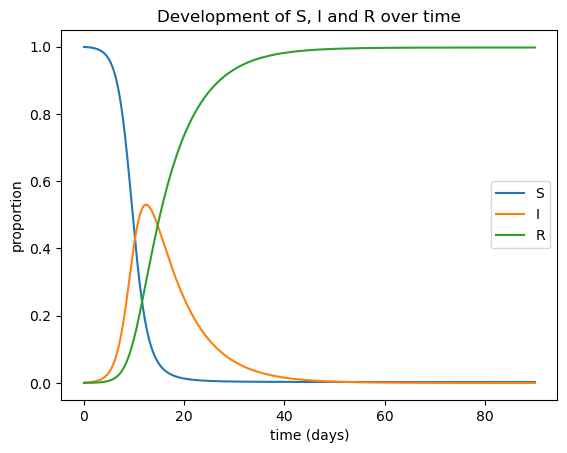

In [4]:
SIR = InfectionModel(k=8, c=0.1, pinf=7)

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))

# Iteration step
step = 10e-3

# Time in days
max_time = 90

# Perform numerical integration
S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

plt.plot(time_log, S_log,label='S')
plt.plot(time_log, I_log,label='I')
plt.plot(time_log, R_log,label='R')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('proportion')
plt.title('Development of S, I and R over time')
plt.show()

The phase space diagrams at different starting values of $S$ and $I$ are plotted by the following utility function:

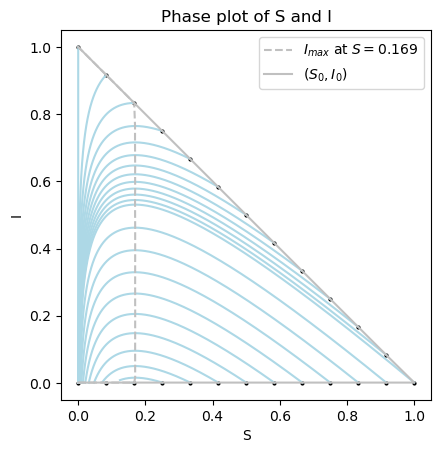

gamma: 0.14285714285714285
beta: 0.8428841252626103
R0: 5.900188876838272


In [5]:
def phase_plots(num_plots, base_pop, max_time, showmax=True, *args):
    
    increment = base_population/(num_plots-1)

    # Track maximum of I
    I_max = []

    # Track level of S at which I is maximum
    S_atmax = []

    # Track starting values of S and I
    S_starts = []
    I_starts = []

    for x in range(num_plots):

        # Determine starting conditions:
        # for first half of the plots - increment X, Y = 1, Z = N - X - 1
        # for second half of the plots - increment Y, X = N - Y, Z = 0
        if x <= num_plots*0.5:
            X_start = x*increment*2
            Y_start = 1
            Z_start = base_population-x*increment*2-1
        else:
            X_start = base_population-(x-math.floor(num_plots*0.5))*increment*2
            Y_start = (x-math.floor(num_plots*0.5))*increment*2
            Z_start = 0

        # Initialize infection model
        SIR = InfectionModel(X_start, Y_start, Z_start, k=args[0], c=args[1], pinf=args[2], beta=args[3], gamma=args[4])

        # Append starting points and mark their positions
        S_starts.append(SIR.S)
        I_starts.append(SIR.I)
        plt.plot(SIR.S,SIR.I,**{'marker':'o', 'markerfacecolor':'k', 'markeredgecolor':'k', 'markersize':2})

        # Track development of infection over time
        S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

        # Track maxima of infection values
        I_max.append(max(I_log))
        S_atmax.append(S_log[np.argmax(I_log)])

        # Plot infection values
        ax = plt.subplot()
        ax.plot(S_log, I_log,color='lightblue')
        ax.set_aspect('equal','box')
    
    plt.xlabel('S')
    plt.ylabel('I')
    plt.title('Phase plot of S and I')

    # Plot maxima and starting points
    if showmax: ax.plot(S_atmax, I_max,linestyle='dashed',color='silver',label='$I_{max}$ at $S=$'+"%.3f"%S_atmax[num_plots//2])
    ax.plot(S_starts, I_starts,color='silver', label='$(S_{0},I_{0})$')
    ax.legend()
    plt.show()
    
    print("gamma: "+str(SIR.gamma))
    print("beta: "+str(SIR.beta))
    print("R0: "+str(SIR.R0))


num_plots = 25
base_population = 1000

# Time in days
max_time = 90

phase_plots(num_plots, base_population, max_time, True, 8, 0.1, 7, None, None)

An alternative set of parameters would guarantee that no epidemic would develop. These should ultimately result in a $R_0$ value smaller than 1, which applies for a sufficiently small $\beta$. This can be influenced by setting the infection probablitity $C$ to a very small number.

To calculate the threshold value for $C$ while keeping the other variables fixed, the equation for $R_0$ can be rewritten:

$$
R_0 = \frac{\beta}{\gamma} = \frac{-\kappa ln(1-C)}{\gamma} \\
\gamma R_0 = -\kappa ln(1-C) \\
ln(1-C)=-\frac{\gamma R_0}{\kappa}
C = 1 - e^{-\frac{\gamma R_0}{\kappa}}
$$

For $\gamma = 1/7$ and $\kappa = 8$ and $R_0 = 1$ this equates to:

$$
C \approx 0.017699
$$

Which implies approximately 1.77% probability for infection given contact with an infected person.

gamma: 0.14285714285714285
beta: 0.12090910248038547
R0: 0.8463637173626983


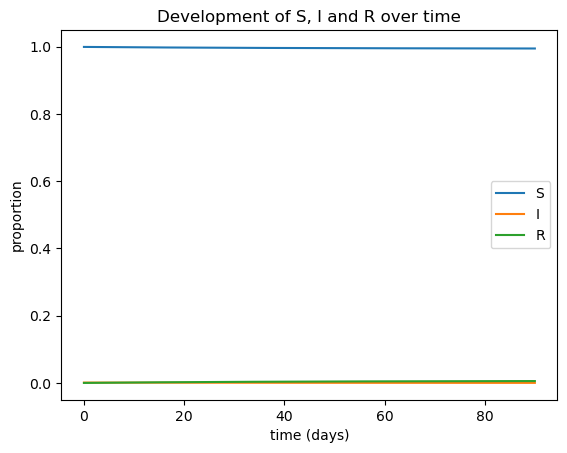

In [6]:
SIR = InfectionModel(k=8, c=0.015, pinf=7)

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))

# Iteration step
step = 10e-3

# Time in days
max_time = 90

# Perform numerical integration
S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

plt.plot(time_log, S_log,label='S')
plt.plot(time_log, I_log,label='I')
plt.plot(time_log, R_log,label='R')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('proportion')
plt.title('Development of S, I and R over time')
plt.show()

The phase plot can be checked for verification:

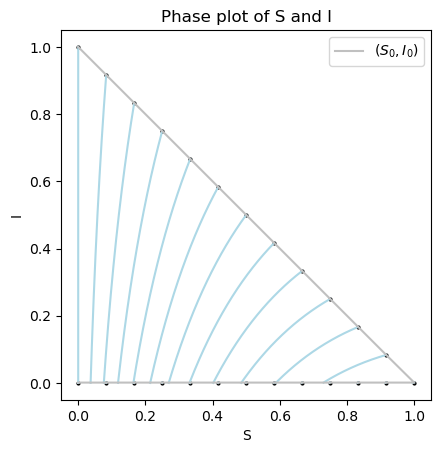

gamma: 0.14285714285714285
beta: 0.12090910248038547
R0: 0.8463637173626983


In [7]:
num_plots = 25
base_population = 1000

# Time in days
max_time = 90

phase_plots(num_plots, base_population, max_time, False, 8, 0.015, 7, None, None)

As expected, all initial states with nonzero $I$ flow almost directly to zero without forming a peak in between.

### 4. Fitting of the SIR model

The data from the influenza outbreak case is saved in an array called `cases`. The data entries represent the number of infected individuals $Y$ and can be plotted against the time of infection:

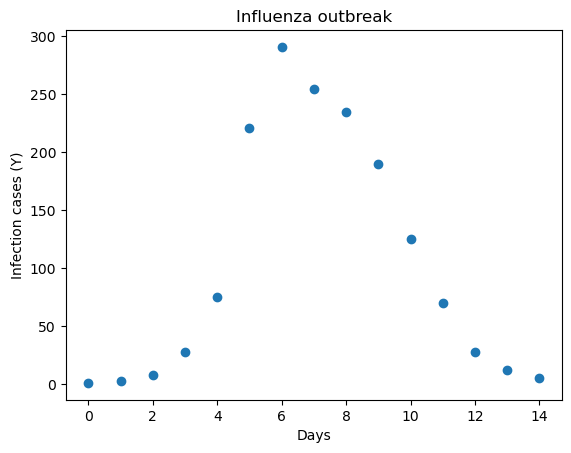

In [8]:
cases = np.array([1,3,8,28,75,221,291,255,235,190,125,70,28,12,5])

days = np.arange(0,15,1)

plt.scatter(days, cases)
plt.xlabel('Days')
plt.ylabel('Infection cases (Y)')
plt.title('Influenza outbreak')
plt.show()

To fit an objective function to the data points, the `scipy.optimize.curve_fit` function will be used.

To enable the implementation of the `InfectionModel` class' `iterate` function, a new class `Tester` is defined, which evaluates the integration only using the necessary parameters for the curve fitting.

R0: 3.716749928047735


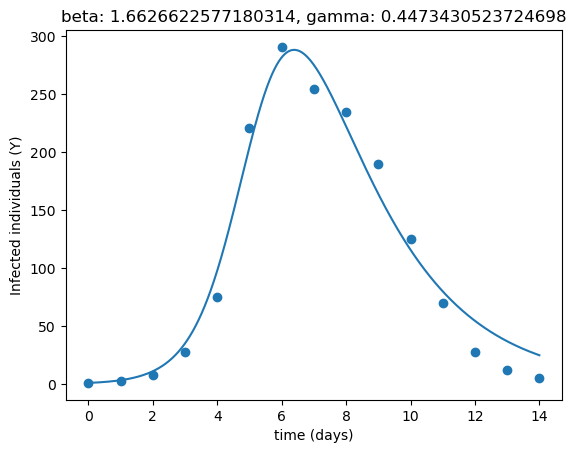

In [9]:
class Tester:
    
    def __init__(self, step, X, Y, Z):
        
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = X+Y+Z
        
        self.step = step
        
    def create_model_and_test(self, times, beta, gamma):

        # Create instance with hard-coded population values and given beta and gamma
        SIR_fit = InfectionModel(self.X,self.Y,self.Z,beta=beta,gamma=gamma)
        
        # Iterate ODEs using last time as duration
        _, infected, _, times_out = SIR_fit.iterate(self.step, times[-1]+1)
        
        # Get a sample of the infected indivisuals only for the given days
        infected_sample = []
        times_ct = 0 # counter
        for i in range(len(times_out)):
            if times_out[i] >= times[times_ct]:
                infected_sample.append(infected[i]*self.N)
                times_ct += 1
                if times_ct >= len(times):
                    break

        return infected_sample

    
# Initial conditions from data
X_start = 762
Y_start = 1
Z_start = 0
N = X_start+Y_start+Z_start
    
tester = Tester(step, X_start, Y_start, Z_start)

params_fit, _ = scipy.optimize.curve_fit(tester.create_model_and_test, days, cases, p0 = [1.8,0.1], bounds = ([0,0],[100,100]), method='trf')

beta_fit, gamma_fit = params_fit

# Recalculate model with fitted parameters
SIR_fitted = InfectionModel(X_start, Y_start, Z_start,beta=beta_fit,gamma=gamma_fit)
S_log, I_log, R_log, time_log = SIR_fitted.iterate(step, days[-1])
print("R0: " + str(SIR_fitted.R0))

# Rescale to population size
Y_log = np.multiply(I_log, N)

# Plot original data points with I-curve of fitted model
plt.scatter(days, cases)
plt.plot(time_log, Y_log,label='Y')
plt.xlabel('time (days)')
plt.ylabel('Infected individuals (Y)')
plt.title('beta: ' + str(beta_fit) + ", gamma: " + str(gamma_fit))
plt.show()

Therefore, the estimated parameters for the infection are $\beta\approx1.6627$, $\gamma\approx0.4473$ and, respectively, $R_0\approx3.7167$.

The phase plot of the disease spread with these parameters is computed below:

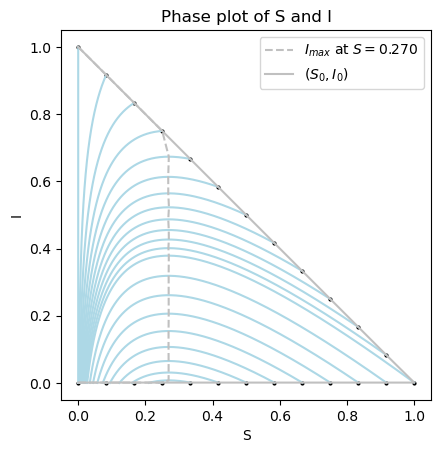

gamma: 0.4473430523724698
beta: 1.6626622577180314
R0: 3.716749928047735


In [10]:
num_plots = 25
base_population = 1000

# Time in days
max_time = 90

phase_plots(num_plots, base_population, max_time, True, None, None, None, beta_fit, gamma_fit)

### 5. Vaccination strategies

One vaccination plan would be to identify how many susceptibles need to be vaccinated (and therefore directly transitioned to the "removed" or "recovered" section) in order to prevent a rise of the infection. Assuming that the vaccination can be carried out within a single day - the day zero of the infection, we can look at the bottom horizontal line of initial conditions for $S$ when $I$ is still minimal. There is a clear indication that if there are less than about 27% (or $\frac{1}{R_0}$) of susceptibles at the beginning of the development, there is no trajectory rising upward - this is the tangent point of most trajectories to the horizontal line of $\frac{dI}{dt}=0$. This means that if more than 73% of the susceptibles are vaccinated initially, the infection will not spread.

Alternatively, if it is not possible to vaccinate such a percentage, a threshold level of infected individuals can be considered which can still be tolerated by the healthcare system. If such a threshold is denoted as $I_T$, one can refer to the phase plot for the starting points of trajectories whose maxima fall below this value.

Setting $I_T=0.1$ (meaning a maximum of 10% of the population may get infected), the admissible vaccination percentages can be calculated by fitting the initial number of susceptibles as a parameter towards minimizing the distance between the trajectory's peak of $I$ (where $\frac{dI}{dt}=0$) and the threshold value $I_T$.

R_start threshold: 0.42892947098938966


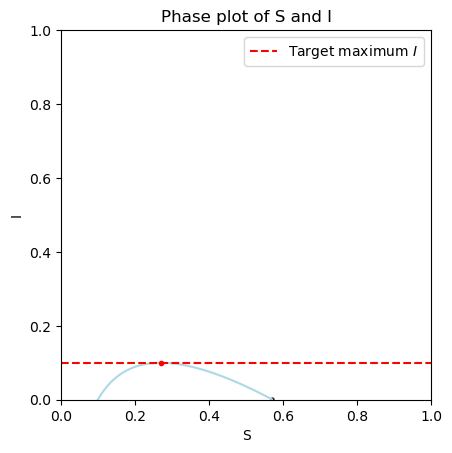

In [11]:
class STester:
    
    def __init__(self, step, max_time, pop_size, beta, gamma, I_thresh):
        
        self.N = pop_size
        self.beta = beta
        self.gamma = gamma
        
        self.step = step
        self.max_time = max_time
        self.I_thresh = I_thresh
        
    def create_model_and_test(self, R_start):

        # Create instance with hard-coded beta and gamma and variable R_start
        SIR_fit = InfectionModel(self.N-R_start*self.N-1, 1, R_start*self.N, beta=self.beta, gamma=self.gamma)
        
        # Iterate ODEs using last time as duration
        _, infected, _, _ = SIR_fit.iterate(self.step, self.max_time)

        return abs(np.max(infected)-self.I_thresh)

s_tester = STester(step, 90, 1000, beta_fit, gamma_fit, 0.1)

# Find starting R that brings the apex closest to I_thresh
minimize = scipy.optimize.minimize_scalar(s_tester.create_model_and_test, bounds=[0,1])

R_start = minimize.x

print(f"R_start threshold: {R_start}")


# Plot trajectory of estimated R_start
base_population = 1000

# Initialize infection model
SIR = InfectionModel(base_population-R_start*base_population-1, 1, R_start*base_population, beta=beta_fit, gamma=gamma_fit)

# Mark starting point position
plt.plot(SIR.S,SIR.I,**{'marker':'o', 'markerfacecolor':'k', 'markeredgecolor':'k', 'markersize':2})

# Track development of infection over time
S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

# Track maxima of infection values
I_max = max(I_log)
S_atmax = S_log[np.argmax(I_log)]

# Plot infection values
ax = plt.subplot()
ax.plot(S_log, I_log,color='lightblue')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_aspect('equal','box')

plt.xlabel('S')
plt.ylabel('I')
plt.title('Phase plot of S and I')

# Plot maximum
ax.plot(S_atmax, I_max,**{'marker':'o', 'markerfacecolor':'r', 'markeredgecolor':'r', 'markersize':3})
ax.hlines(I_max, 0, 1, linestyles='dashed', colors='r', label='Target maximum $I$')
plt.legend()
plt.show()

This way we can deduce that for a maximum infected proportion of $0.1$ it is necessary to vaccinate about 43% of the individuals.

When the population in question is too large, it might not be possible to vaccinate everyone within the first day of infection. Therefore, another way to explore the dynamics of the system with vaccination involved is to incorporate a vaccination term $\alpha$ in the model, which represents a proportion of the population vaccinated per day (assuming a vaccination starts working immediately).

Realistically $\alpha$ is more likely to represent an absolute amount of vaccinations per day and can thus be an amount subtracted from the susceptible indiviuals $X$ and added to the recovered ones $Z$. The new term can be incorporated in the ODEs as follows:

$$
\frac{dS}{dt}=-\beta S I - \alpha \\
\frac{dI}{dt}= \beta S I - \gamma I\\
\frac{dR}{dt}= \gamma I + \alpha
$$

Where we still respect the condition $\frac{dS}{dt}+\frac{dI}{dt}+\frac{dR}{dt}=0$. 

Thus the infection model can be extended and the threshold value of $v$ can be found for which an epidemic can be alleviated.

In [12]:
class InfectionModelVaccination(InfectionModel):
    
    # Extends __init__() with alpha
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, alpha=0.01, beta=None, gamma=None, mu=None):
        super(InfectionModelVaccination, self).__init__(X, Y, Z, k, c, pinf, beta, gamma)
        
        self.alpha = alpha
        self.ode = self.SIR_v
    
    # Adds ODEs for vaccination model
    def SIR_v(self, sir):
        
        self.dS = -self.beta*sir[0]*sir[1] - alpha
        self.dI = self.beta*sir[0]*sir[1] - self.gamma*sir[1]
        self.dR = self.gamma*sir[1] + alpha
        
        return np.array([self.dS, self.dI, self.dR])

First, different trajectories of $S$ and $I$ can be explored through phase plots using different values of $v$:

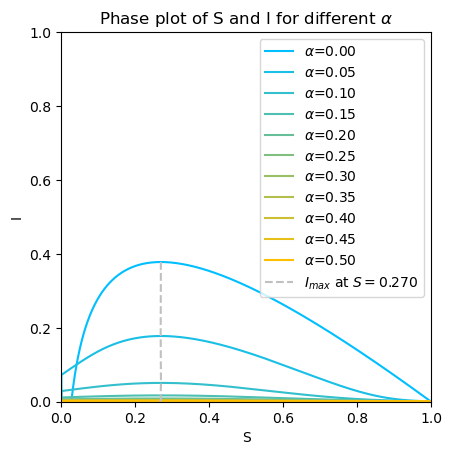

In [13]:
num_plots = 11
alpha_range = np.linspace(0,0.5,num_plots)

base_population = 1000

# Time in days
max_time = 90

# Track maximum of I
I_max = []

# Track level of S at which I is maximum
S_atmax = []

for alpha in alpha_range:

    # Initialize infection model
    SIR = InfectionModelVaccination(base_population-1, 1, 0, beta=beta_fit, gamma=gamma_fit, alpha=alpha)

    # Track development of infection over time
    S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

    # Track maxima of infection values
    I_max.append(max(I_log))
    S_atmax.append(S_log[np.argmax(I_log)])

    # Plot infection values
    ax = plt.subplot()
    ax.plot(S_log, I_log,color=(alpha*2,0.75,1-alpha*2),label='$\\alpha$='+'%.2f'%alpha)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_aspect('equal','box')

plt.xlabel('S')
plt.ylabel('I')

plt.title('Phase plot of S and I for different $\\alpha$')

# Plot maxima and starting points
ax.plot(S_atmax, I_max,linestyle='dashed',color='silver',label='$I_{max}$ at $S=$'+"%.3f"%S_atmax[num_plots//2])
ax.legend()
plt.show()


The results show that already at $v=0.15$ the peak of infecteds becomes negligible. An interesting effect that can be observed is that for intermediate values $0 < v < 0.15$ the number of susceptibles may run out before the number of infecteds - a topic for further discussion.

Based on this model it can be deduced that if the strategy is to vaccinate 15% of the population per day, the effect of the infection could be alleviated. The interpretation of $v$ is subject to further discussion.

### 6. SIR model with demography

### 6.1 Class extension
To incorporate demography into the model, an extension of the class `InfectionModel` called `InfectionModelDemography` is defined, which implements the new equations taking into account the birth/death rate $\mu$.

The new model now incorporates the following ODEs:

$$
\frac{dS}{dt}=\mu-\beta S I - \mu S \\
\frac{dI}{dt}=\beta S I - \gamma I - \mu I \\
\frac{dR}{dt}=\gamma I - \mu R
$$

$\mu$ can either be supplied explicitly, or calculated from the inverse of an average human lifespan, when provided.

$R_0$ is also redefined to incorporate the demographics parameter, so that $R_0=\frac{\beta}{\gamma+\mu}$.

In [14]:
class InfectionModelDemography(InfectionModel):
    
    # Extends __init__() with mu
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None):
        super(InfectionModelDemography, self).__init__(X, Y, Z, k, c, pinf, beta, gamma)
        if mu:
            self.mu = mu
        else:
            self.mu = 1/lifespan
        
        self.R0 = self.beta/(self.gamma+self.mu)
        self.ode = self.SIR_d
    
    # Adds ODEs for demography model
    def SIR_d(self, sir):
        
        self.dS = self.mu - self.beta*self.S*self.I - self.mu*self.S
        self.dI = self.beta*self.S*self.I - self.gamma*self.I - self.mu*self.I
        self.dR = self.gamma*self.I - self.mu*self.R
        
        return np.array([self.dS, self.dI, self.dR])

### 6.2. Analysis of the behaviour
The dynamics of the system are plotted using the same time period and step size as the previous model. $\mu$ is in this case based on the meadian age in the EU for 2022, which is 44.1 years, or translated in days: $44.1*(365*3+366)/4=16107.525$.

As the supporting literature states[2](#references) a stable oscillatory equilibrium around an endemic states appears whenever $R_0>1$. Due to the time-scale difference between the recovery rate and the birth/death rate, the oscillations in the system only become visible over a longer observed time period - about 5 years in this case.

In this example, the infection probablitity is increased to 0.5 to amplify the oscillations.

gamma: 0.14285714285714285
beta: 5.545177444479562
R0: 38.79938069628082
mu: 6.208278428870977e-05


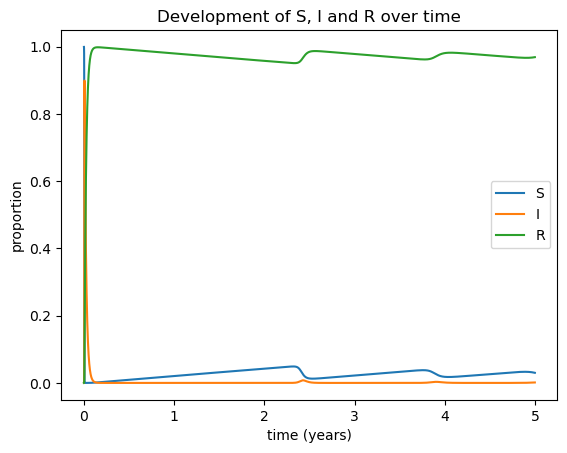

In [15]:
SIR = InfectionModelDemography(k=8, c=0.5, pinf=7, lifespan = 16107.525)

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))
print("mu: "+str(SIR.mu))

# Iteration step
step = 10e-2

# Time in days (equivalent to 5 years)
max_time = 1826

# Terform numerical integration
S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

# Scale time to years
time_log = np.multiply(time_log, 1/365.25)

plt.plot(time_log, S_log,label='S')
plt.plot(time_log, I_log,label='I')
plt.plot(time_log, R_log,label='R')
plt.legend()
plt.xlabel('time (years)')
plt.ylabel('proportion')
plt.title('Development of S, I and R over time')
plt.show()

Phase space diagrams provide a better understanding of the system's dynamics by plotting the trajectories of $S$ against $I$ over time. However, it is visible from the previous plot that the oscillations around the fixed point of $I$ are quite close to zero, so in order to perceive the location of the stable point $(S^*, I^*)$ for endemic equilibrium cases (when $R_0>1$) [2](#references) (p.29), one can consider the equation:

$$
I^*=\frac{\mu}{\beta}(R_0-1)
$$

Which is equivalent to:

$$
I^*=\frac{\mu}{\beta}(\frac{\beta}{\gamma+\mu}-1)=\mu(\frac{1}{\gamma+\mu}+\frac{1}{\beta})
$$

If $\mu$ is kept fixed, since it is based on a standard population metric, $\gamma$ and $\beta$ can be varied in order to explore the different possible values for $I^*$ and see at what combination of parameters it is most pronounced.

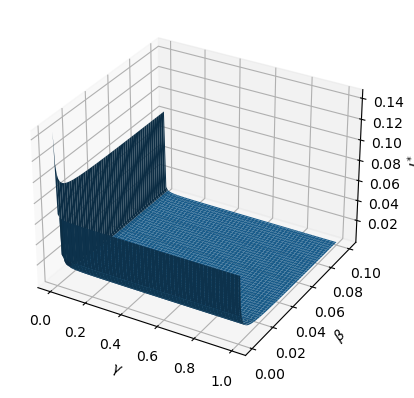

In [16]:
mu = 1/16107.525 # constant
gamma_range = np.linspace(1/1461,1,100) # period of infection - 1 day to 5 years
beta_range = np.linspace(10e-4,10e-2,100)

gamma_2D = np.array([[g for g in gamma_range] for _ in beta_range])
beta_2D = np.array([[b for _ in gamma_range] for b in beta_range])
I_2D = np.array([[mu*(1/(g+mu)+1/b) for g in gamma_range] for b in beta_range])

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(gamma_2D, beta_2D, I_2D)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$I^*$')
plt.show()

It therefore becomes apparent that the $I^*$ coordinate of the fixed point only gains a significant value when either $\gamma$ is really small (an infection period of a year) or when $\beta$ is very small.

Since some diseases can indeed have a prolonged infectious period, a $\gamma$ corresponding to a five-year infectious period can be tested together with a very small infection probability $C$ in order to observe the behaviour around the stable fixed point in a phase plot over the course of 70 years.


gamma: 0.0005475701574264203
beta: 0.0020002500416742603
R0: 3.2809651275477787


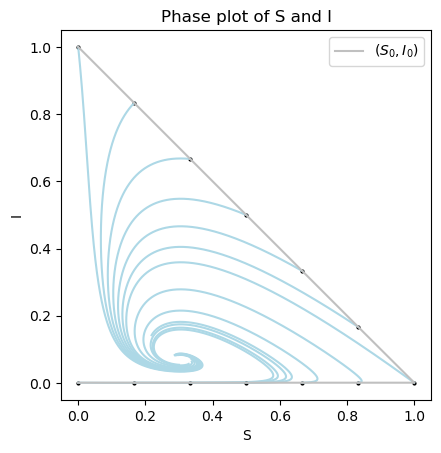

In [17]:
num_plots = 13
base_population = 1200
increment = base_population/(num_plots-1)

# Iteration step
step = 10e-2

# Time in days (equivalent to 70 years)
max_time = 25567.5

# Track starting values of S and I
S_starts = []
I_starts = []

for x in range(num_plots):
    
    # Determine starting conditions:
    # for first half of the plots - increment X, Y = 1, Z = N - X - 1
    # for second half of the plots - increment Y, X = N - Y, Z = 0
    if x <= num_plots*0.5:
        X_start = x*increment*2
        Y_start = 1
        Z_start = base_population-x*increment*2-1
    else:
        X_start = base_population-(x-math.floor(num_plots*0.5))*increment*2
        Y_start = (x-math.floor(num_plots*0.5))*increment*2
        Z_start = 0
    
    # Initialize infection model
    SIR = InfectionModelDemography(X_start, Y_start, Z_start, k=8, c=0.00025, pinf=1826.25, lifespan = 16107.525)
    
    # Append starting points and mark their positions
    S_starts.append(SIR.S)
    I_starts.append(SIR.I)
    plt.plot(SIR.S,SIR.I,**{'marker':'o', 'markerfacecolor':'k', 'markeredgecolor':'k', 'markersize':2})
    
    # Track development of infection over time
    S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)
    
    # Plot infection values
    ax = plt.subplot()
    ax.plot(S_log, I_log,color='lightblue')
    ax.set_aspect('equal','box')
    plt.xlabel('S')
    plt.ylabel('I')
    plt.title('Phase plot of S and I')

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))
    
# Plot starting points
ax.plot(S_starts, I_starts,color='silver', label='$(S_{0},I_{0})$')
ax.legend()
plt.show()

Thus the oscillations about the stable point $(S^*, I^*)$ become visible.

From the derivation in the book of Keeling et al[1](#references) is is known that the stable fixed point for the SIR model with demography is:

$$
(S^*,I^*,R^*)=(\frac{1}{R_0}, \frac{\mu}{\beta}(R_0-1), 1-\frac{1}{R_0}-\frac{\mu}{\beta}(R_0-1))
$$

We can therefore calculate this fixed point using our current parameters:

In [18]:
SIR = InfectionModelDemography(k=8, c=0.00025, pinf=1826.25, lifespan = 16107.525)

equilibrium_pt = [1/SIR.R0, SIR.mu*(SIR.R0-1)/SIR.beta, 1-1/SIR.R0-SIR.mu*(SIR.R0-1)/SIR.beta]

print(f"[S*,I*,R*]={equilibrium_pt}")

[S*,I*,R*]=[0.3047883659609051, 0.07079548208137422, 0.6244161519577207]


Which aligns with the observations in the phase plot.

### 6.3. Oscillations analysis

The endemic state is represented by a stable spiral due to the fact that the eigenvalue analysis at the equilibrium point results in eigenvalues containing complex terms:

$$
\lambda\approx -\frac{\mu R_0}{2}\pm \frac{i}{\sqrt{AG}}
$$

Where $A=\frac{1}{\mu(R_0-1)}$ stands for the mean age of infection and $G=\frac{1}{\mu+\gamma}$ represents the typical infectivity period for a host. $\frac{1}{\sqrt{AG}}$ is the factor of the imaginary part of the lambda values. The general solution of a dynamical system (in this case a 2D one) can be expressed as a function of the eigenvectors and eigenvalues [3](#references):

$$
\vec x(t) = c_1 e^{\lambda_1 t} v_1 + c_2 e^{\lambda_2 t} v_2
$$

With $\lambda$ being complex, this means that the equation involves terms of the form $e^{(\alpha+i\omega) t}$. Euler's formula states that:

$$
e^{i\omega t}=cos(\omega t)+i sin(\omega t)
$$

Which suggests that the factor multiplying the imaginary part of the eigenvalue, in our case $\omega = \frac{1}{\sqrt{AG}}$, determines the frequency of the oscillations. If one full cycle around the fixed point is denoted by an angular period of $2\pi$, then the period of the oscillations is $T=2\pi\sqrt{AG}$ being the inverse of the frequency $\frac{1}{2\pi\sqrt{AG}}$.

The real part of the eigenvalue can be interpreted as the decay rate of the amplitude. Since $-\frac{\mu R_0}{2}$ is always negative, there would always be a decreasing amplitude and thus stable attraction towards the equilibrium point.

The period and the decay rate can be calculated for our current example:

In [19]:
A = 1/(SIR.mu*(SIR.R0-1))
G = 1/(SIR.mu+SIR.gamma)

T = 2*math.pi*math.sqrt(A*G)
dr = -(SIR.mu*SIR.R0/2)

print(f"Period of oscillations T: {T} days or {T/365.25} years")
print(f"Frequency of oscillations: {365.25/T} per year")
print(f"Decay rate: {dr}")

Period of oscillations T: 21384.229943671213 days or 58.54683078349408 years
Frequency of oscillations: 0.017080343831043485 per year
Decay rate: -0.00010184572513616395


These calculations can be verified using a Fourier analysis on the results of the current model. Reading this values we note that the oscillation period is equal to approx. 58 and a half years, which is relatively long compared to a human life expectancy. Therefore it is necessary to observe a longer period to distinguish the oscillation patterns more clearly.

gamma: 0.0005475701574264203
beta: 0.0020002500416742603
R0: 3.2809651275477787
mu: 6.208278428870977e-05


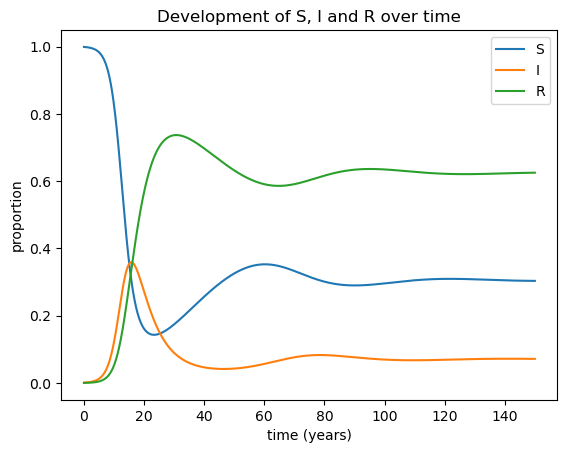

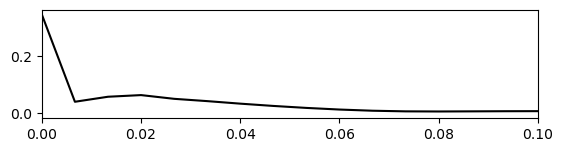

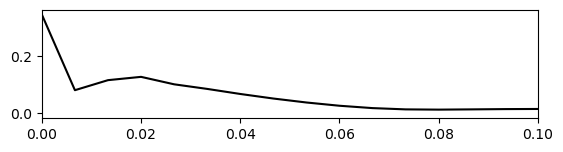

In [20]:
#%matplotlib notebook

SIR = InfectionModelDemography(k=8, c=0.00025, pinf=1826.25, lifespan = 16107.525)
#SIR = InfectionModelDemography(k=8, c=0.25, pinf=5, lifespan = 44.1)
#SIR = InfectionModelDemography(k=10, c=0.5, pinf=7, lifespan = 16107.525)

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))
print("mu: "+str(SIR.mu))

# Iteration step
step = 10e-2

# Time in days (equivalent to 150 years)
max_time = 54787.5

# Terform numerical integration
S_log, I_log, R_log, time_log = SIR.iterate(step, max_time)

# Scale time to years
time_log = np.multiply(time_log, 1/365.25)

plt.plot(time_log, S_log,label='S')
plt.plot(time_log, I_log,label='I')
plt.plot(time_log, R_log,label='R')
plt.legend()
plt.xlabel('time (years)')
plt.ylabel('proportion')
plt.title('Development of S, I and R over time')
plt.show()

# Normalize using 'forward' to compensate for number of samples
fourier = fftshift(fft(S_log, norm='forward'))
# Use dt to determine correct frequencies
dt = (max(time_log) - min(time_log)) / len(S_log)
freq = fftshift(fftfreq(len(I_log), d=dt))

# To preserve amplitudes (we show half the spectrum), we need to compensate
comp = 2
spectrum = comp*np.abs(fourier)
centerIdx = len(S_log)//2
spectrum[centerIdx] /= comp

fig = plt.figure()
ax = fig.add_subplot(313)
ax.set_xlim([0, 0.1])
ax.plot(freq, spectrum, c='k', label='f')

Indeed, the plot of the Fourier analysis shows a peak around 0.02, which corresponds to the previous calculation.

### 7. Infection-induced mortality term

Incorporating an infection-induced mortality term implies extending the `InfectionModel` class with an updated set of ODEs where the rate of change of the infected compartment becomes:

$$
\frac{dI}{dt} = \beta S I - \frac{(\gamma+\mu)}{1-\rho}I
$$

With $\rho$ being the probability of an infected individual dying from the infection before moving to the $R$ compartment or dying from natural causes.

Furthermore, to prevent an ever-declining population size, a fixed birth rate [2](#references) (p.34) $v$ is introduced in the rate of change for $S$, which is decoupled from the natural mortality rate $\mu$:

$$
\frac{dS}{dt} = v - \beta S I - \mu S
$$

Finally, $R_0$ needs to be updated so that:

$$
R_0 = \frac{\beta (1-\rho) v}{(\mu+\gamma)\mu}
$$

In [21]:
class InfectionModelDemIIMD(InfectionModel):
    
    # Extends __init__() with mu and rho and v
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None, rho=None, v=None):
        super(InfectionModelDemIIMD, self).__init__(X, Y, Z, k, c, pinf, beta, gamma)
        if mu:
            self.mu = mu
        else:
            self.mu = 1/lifespan
        
        self.rho = rho
        self.v = v
        self.R0 = self.beta*(1-self.rho)*self.v/((self.gamma+self.mu)*self.mu)
        self.ode = self.SIR_m
    
    # Adds ODEs for infection-induced mortality model
    def SIR_m(self, sir):
        
        self.dS = self.v - self.beta*self.S*self.I - self.mu*self.S
        self.dI = self.beta*self.S*self.I - self.I*(self.gamma+self.mu)/(1-self.rho)
        self.dR = self.gamma*self.I - self.mu*self.R
        
        return np.array([self.dS, self.dI, self.dR])

The behaviour of the model is first explored for several values of $\rho$ (0.25, 0.5, and 0.75) through separate phase plots, in which $v$ has a fixed value. The rest of the parameters are kept as before.

To find an appropriate value for $v$ one can think of $\frac{v}{\mu}$ as the carrying capacity of the population $N$ (viewed as a proportion). In a stable population this fraction would be approximately equal to 1, so it would be safe to assume a value of $v$ similar to $\mu$.

Due to the varying size of $N$ this time the population compartments are set as the absolute number of individuals $X$ and $Y$ instead of normalized proportions of the population.

gamma: 0.0006844626967830253
beta: 0.004001000333457943
R0: 1.0790737893768987


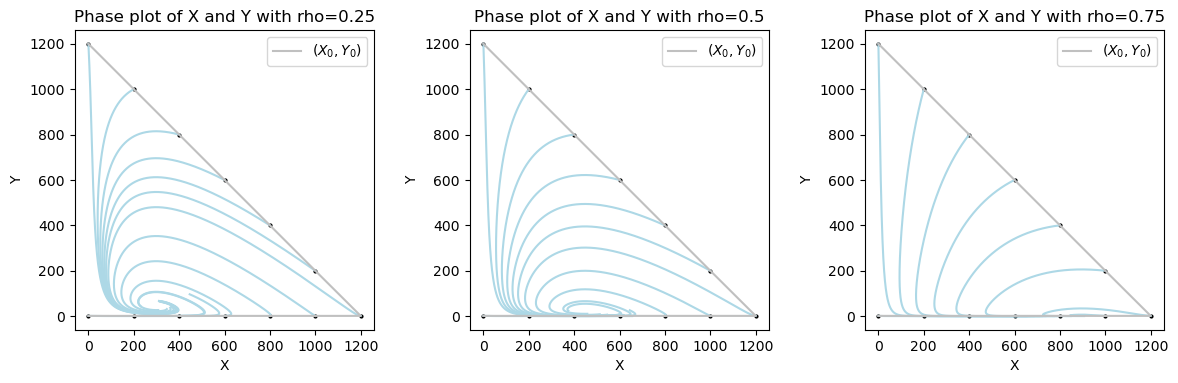

In [50]:
num_plots = 13
base_population = 1200
increment = base_population/(num_plots-1)

# Iteration step
step = 10e-2

# Time in days (equivalent to 50 years)
max_time = 18260

rhos = [0.25,0.5,0.75]
v = 1/20000

fig, axs = plt.subplots(1,3,sharex=True)
fig.set_size_inches(12,4)

for i in range(len(rhos)):

    # Track starting values of S and I
    X_starts = []
    Y_starts = []

    for x in range(num_plots):

        # Determine starting conditions:
        # for first half of the plots - increment X, Y = 1, Z = N - X - 1
        # for second half of the plots - increment Y, X = N - Y, Z = 0
        if x <= num_plots*0.5:
            X_start = x*increment*2
            Y_start = 1
            Z_start = base_population-x*increment*2-1
        else:
            X_start = base_population-(x-math.floor(num_plots*0.5))*increment*2
            Y_start = (x-math.floor(num_plots*0.5))*increment*2
            Z_start = 0

        # Initialize infection model
        SIR = InfectionModelDemIIMD(X_start, Y_start, Z_start, k=8, c=0.0005, pinf=1461, lifespan = 16107.525, rho=rhos[i], v=v)

        # Append starting points and mark their positions
        X_starts.append(X_start)
        Y_starts.append(Y_start)
        axs[i].plot(X_start,Y_start,**{'marker':'o', 'markerfacecolor':'k', 'markeredgecolor':'k', 'markersize':2})

        # Track development of infection over time
        S_log, I_log, R_log, time_log = SIR.iterate(step, max_time, constrain=False)
        
        X_log = np.multiply(S_log, base_population)
        Y_log = np.multiply(I_log, base_population)
        Z_log = np.multiply(R_log, base_population)

        # Plot infection values
        #axs[i] = plt.subplot()
        axs[i].plot(X_log, Y_log,color='lightblue')
        axs[i].set_aspect('equal','box')
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Y')
        axs[i].set_title(f'Phase plot of X and Y with rho={rhos[i]}')

    # Plot starting points
    axs[i].plot(X_starts, Y_starts,color='silver', label='$(X_{0},Y_{0})$')
    axs[i].legend()

print("gamma: "+str(SIR.gamma))
print("beta: "+str(SIR.beta))
print("R0: "+str(SIR.R0))
plt.tight_layout()
plt.show()

These plots already give an indication of how a disease can only persevere to an endemic state if it is not too deadly.

Knowing that the fixed points of this system exist at $(\frac{v}{\mu})$ and $(X^*,Y^*,Z^*)$ where:

$$
X^*=\frac{v}{\mu R_0}\\
Y^*=\frac{\mu}{\beta}(R_0-1)\\
Z^*=\frac{\gamma}{\beta}(R_0-1)
$$

We notice that since $R_0$ has negative linear relationship to $\rho$, the same would apply for $Y^*$ and $Z^*$. On the other hand, $X^*$ would be inversely proportional to the _decrease_ in $\rho$. This confirms the observations from the phase plots that with $\rho$ approaching 1 the disease burns out so rapidly that it leaves a very small fraction of infected and recovered, but a much larger fraction of susceptibles, driven mostly by their demographic rates.

The positions of the fixed point $(X^*,Y^*,Z^*)$ can be explored for varying values of $\rho$:

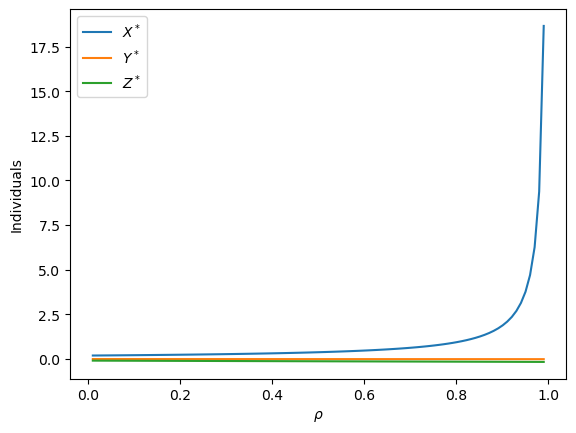

In [52]:
rho_range = np.linspace(0.01,0.99,100)

fp_track = []

for rho in rho_range:
    
    SIR = InfectionModelDemIIMD(k=8, c=0.0005, pinf=1461, lifespan = 16107.525, rho=rho, v=1/200000)
    
    # Calculate fixed points
    X_fp = SIR.v/(SIR.mu*SIR.R0)
    Y_fp = SIR.mu*(SIR.R0-1)/SIR.beta
    Z_fp = SIR.gamma*(SIR.R0-1)/SIR.beta
    
    fp_track.append([X_fp, Y_fp, Z_fp])
    
fp_track = np.array(fp_track).T

"""fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot(fp_track[0], fp_track[1], fp_track[2])
ax.set_xlabel(r'$X^*$')
ax.set_ylabel(r'$Y^*$')
ax.set_zlabel(r'$Z^*$')"""

plt.plot(rho_range,fp_track[0],label='$X^*$')
plt.plot(rho_range,fp_track[1],label='$Y^*$')
plt.plot(rho_range,fp_track[2],label='$Z^*$')
plt.xlabel('$\\rho$')
plt.ylabel('Individuals')
plt.legend()
plt.show()

### 8. Multi-host model

The extension of the SIR model chosen for further examination is a multi-host model with vectored transmission, e.g. via mosquitoes. This is characterised by two systems of $S$, $I$ and $R$ that do not transmit infection within their own group but rather across groups.

### 8.1. Multi-host model class

Due to the increased complexity of the model the class is structured in a different way compared to the previous infection models. 

In [ ]:
class InfectionModelMultiHost():

<a id='references'></a>
[1] Kutta, Wilhelm - Beitrag zur näherungsweisen Integration totaler Differentialgleichungen (1901, Zeitschrift für Mathematik und Physik)

[2] Keeling, Matt J., Rohani, Pejman - Modeling Infectious Diseases in Humans and Animals (2007, Princeton University Press)

[3] Strogatz, Steven H - Nonlinear Dynamics and Chaos: With Applications to Physics, Biology, Chemistry, and Engineering (2018, CRC press)